# Imports

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import os, re, sys, scipy, pyemma, copy


from glob import glob

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import cartopy.crs as ccrs
from xplor.functions.analysis import add_reference_to_map, appendLonLatTraj, center_ref_and_load

Redefining os.path.isfile to work with tmp_stringio.pdb
Redefining open() to work with tmp_stringio.pdb


/home/kevin/projects/encoder_map_private/encodermap/loading/features.py:36: UserWarning: Features need Unittests
  warnings.warn("Features need Unittests")


In [3]:
DENDROGRAMS = {'k6': {0: [4], 1: [0, 11, 6, 2, 5, 8, 7, 9], 2: [3, 12], 3: [1, 10]},
               'k29': {0: [0], 1: [7, 4, 12, 5, 1, 17], 2: [2, 9, 15, 6, 8], 3: [11, 13], 4: [10, 14, 3, 16]},
               'k33': {0: [12, 22, 17], 1: [3, 7], 2: [4, 15, 19, 13, 20], 3: [9, 8, 14], 4: [11, 0, 2, 6, 10, 21, 1, 5], 5: [23], 6: [16, 18]}
              }



UBQ_SITES = ['k6', 'k29', 'k33']
NBINS = 200

# GitHub colors tmp

## Create the data

In [4]:
aa_df = pd.read_hdf('/home/kevin/git/xplor_functions/xplor/data/all_frames_sPRE_sim.h5', 'aa_df')

In [5]:
polar_coordinates = {}
overwrite = False
ref, idx, labels = center_ref_and_load()

for ubq_site in UBQ_SITES:
    file = f'/mnt/data/kevin/xplor_analysis_files/polar_coordinates_aa_{ubq_site}_after_new_psol_all_coords.npy'
    if not os.path.isfile(file) or overwrite:
        sub_df = aa_df[aa_df[('data', '', 'ubq_site')] == ubq_site]
        sub_df.reset_index()
        polar_coordinates[ubq_site] = []
        for i, (traj_file, df) in enumerate(sub_df.groupby('traj_file')):
            if i % 20 == 0:
                print(i, traj_file)
            top_file = df[('data', '', 'top_file')].unique()
            assert len(top_file) == 1
            top_file = top_file[0]
            frames = df.index.get_level_values(1)
            traj = md.load(traj_file, top=top_file)[frames]
            
            # make sure the three test CAs shift their position
            test_CAs1 = np.array([traj.top.select(f'name CA and resid {75 + i}')[0] for i in [1, 39, 76]])
            test_CAs1 = copy.deepcopy(np.mean(traj.xyz[:, test_CAs1[:, np.newaxis], :3], 0))
            print(test_CAs1)
            
            # make sure LYS6 is LYQ
            test_residue = traj.top.select(f'resid {6 + 75}')
            test_residue = traj.top.atom(test_residue[0])
            if ubq_site == 'k6':
                assert test_residue.residue.name == 'LYQ'
            
            # do superpose
            traj = traj.superpose(reference=ref, ref_atom_indices=idx, atom_indices=traj.top.select('name CA and resid >= 76'))
            
            # make sure coordinates have changed
            # make sure the three test CAs shift their position
            test_CAs2 = np.array([traj.top.select(f'name CA and resid {75 + i}')[0] for i in [1, 39, 76]])
            test_CAs2 = copy.deepcopy(np.mean(traj.xyz[:, test_CAs2[:, np.newaxis], :3], 0))
            print(test_CAs2)
            
            assert not np.array_equal(test_CAs1, test_CAs2)
            
            dist_ind = traj.top.select('resid < 76')
            coords = appendLonLatTraj(traj.xyz)
            polar_coordinates[ubq_site].append(coords[:, :, :])
        polar_coordinates[ubq_site] = np.vstack(polar_coordinates[ubq_site])
        np.save(file, polar_coordinates[ubq_site])
    else:
        polar_coordinates[ubq_site] = np.load(file)

In [11]:
polar_coordinates_dist_centered = {ubq_site: np.load(f'/mnt/data/kevin/xplor_analysis_files/polar_coordinates_aa_{ubq_site}_after_new_psol_centered_distal.npy') for ubq_site in UBQ_SITES}

# Polar plots for superclusters

In [36]:
%matplotlib notebook

In [61]:
from xplor.functions.analysis import center_ref_and_load
cryst, CA_ind, resnames = center_ref_and_load()

<IPython.core.display.Javascript object>


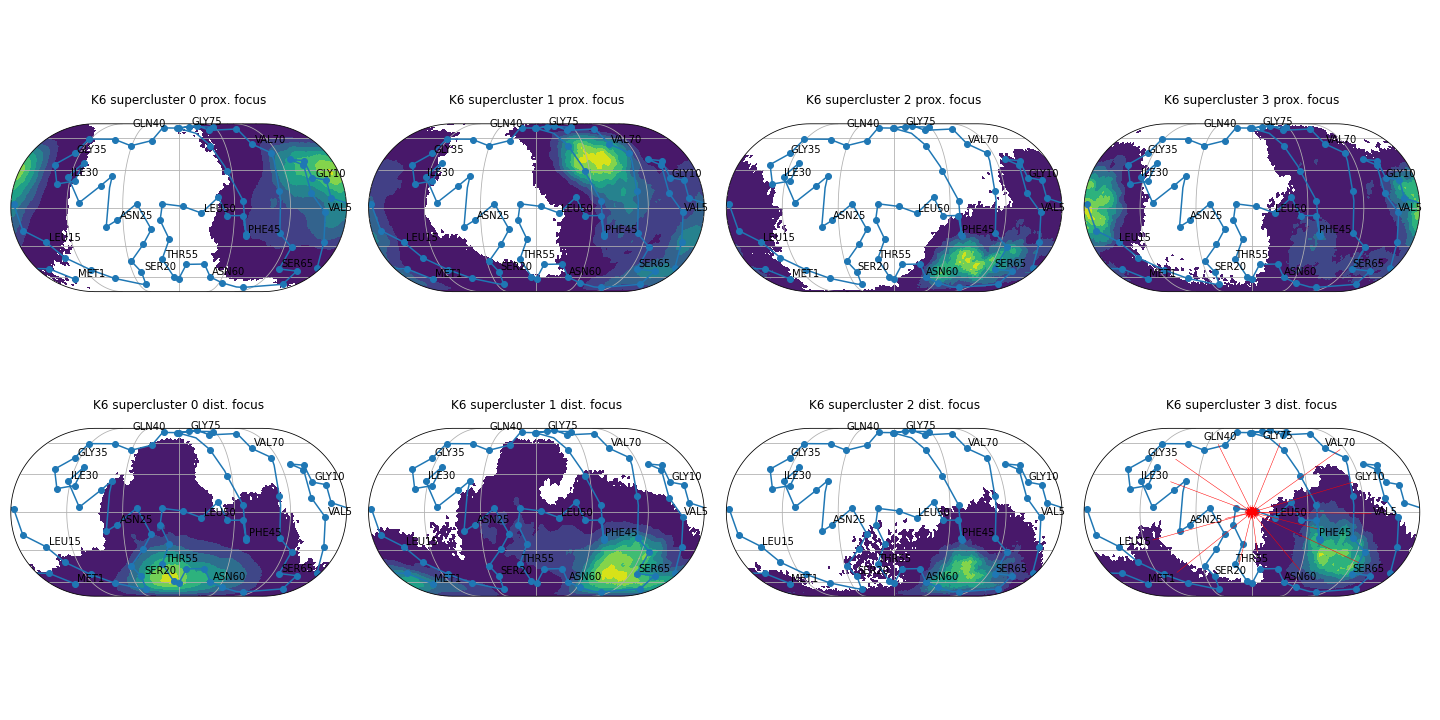

k6 0 [4]
k6 1 [0, 11, 6, 2, 5, 8, 7, 9]
k6 2 [3, 12]
k6 3 [1, 10]


<IPython.core.display.Javascript object>


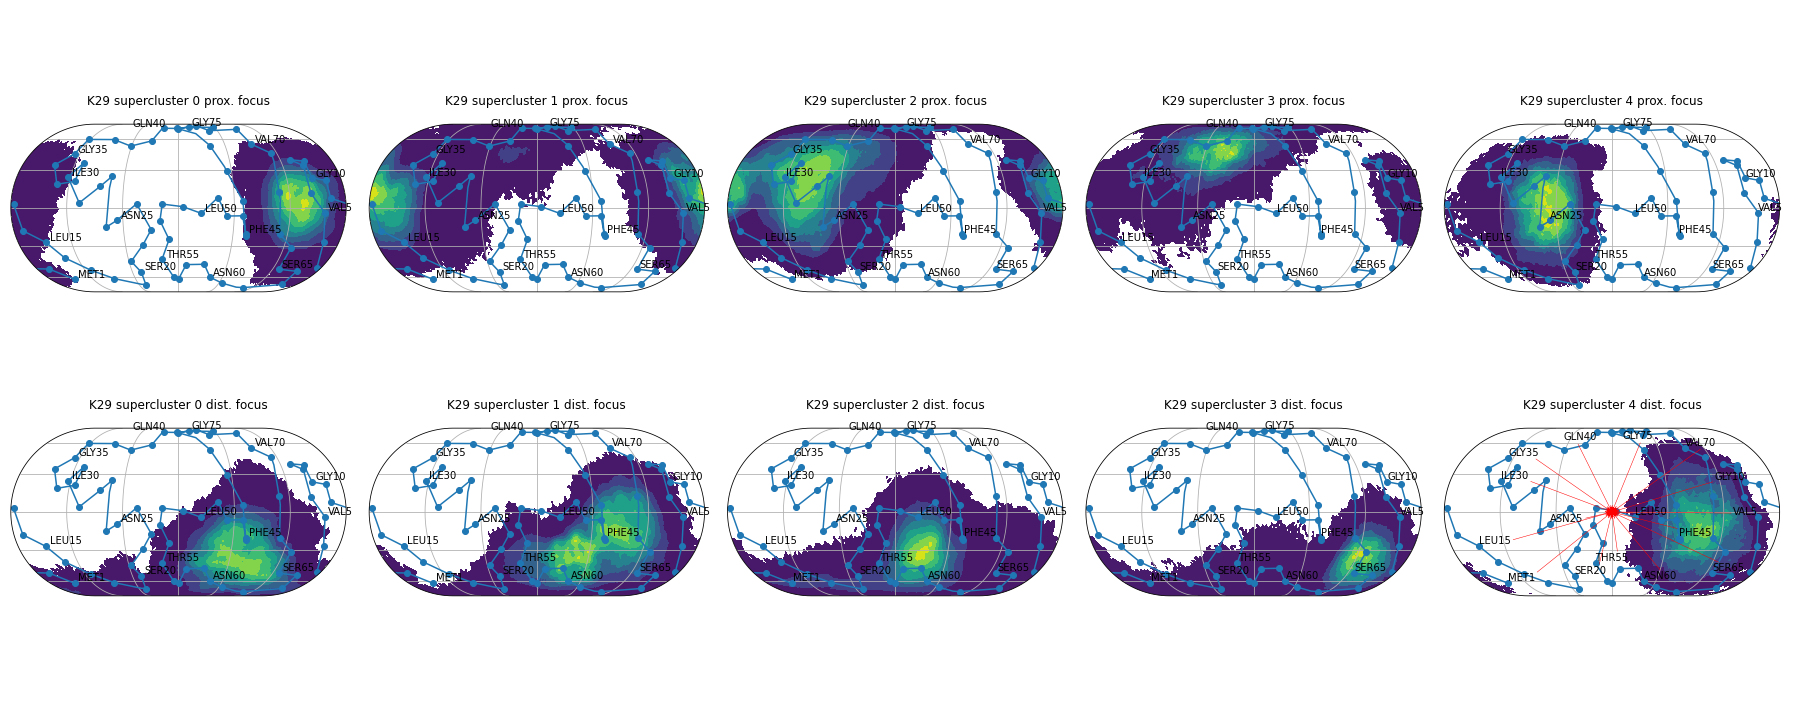

k29 0 [0]
k29 1 [7, 4, 12, 5, 1, 17]
k29 2 [2, 9, 15, 6, 8]
k29 3 [11, 13]
k29 4 [10, 14, 3, 16]


<IPython.core.display.Javascript object>


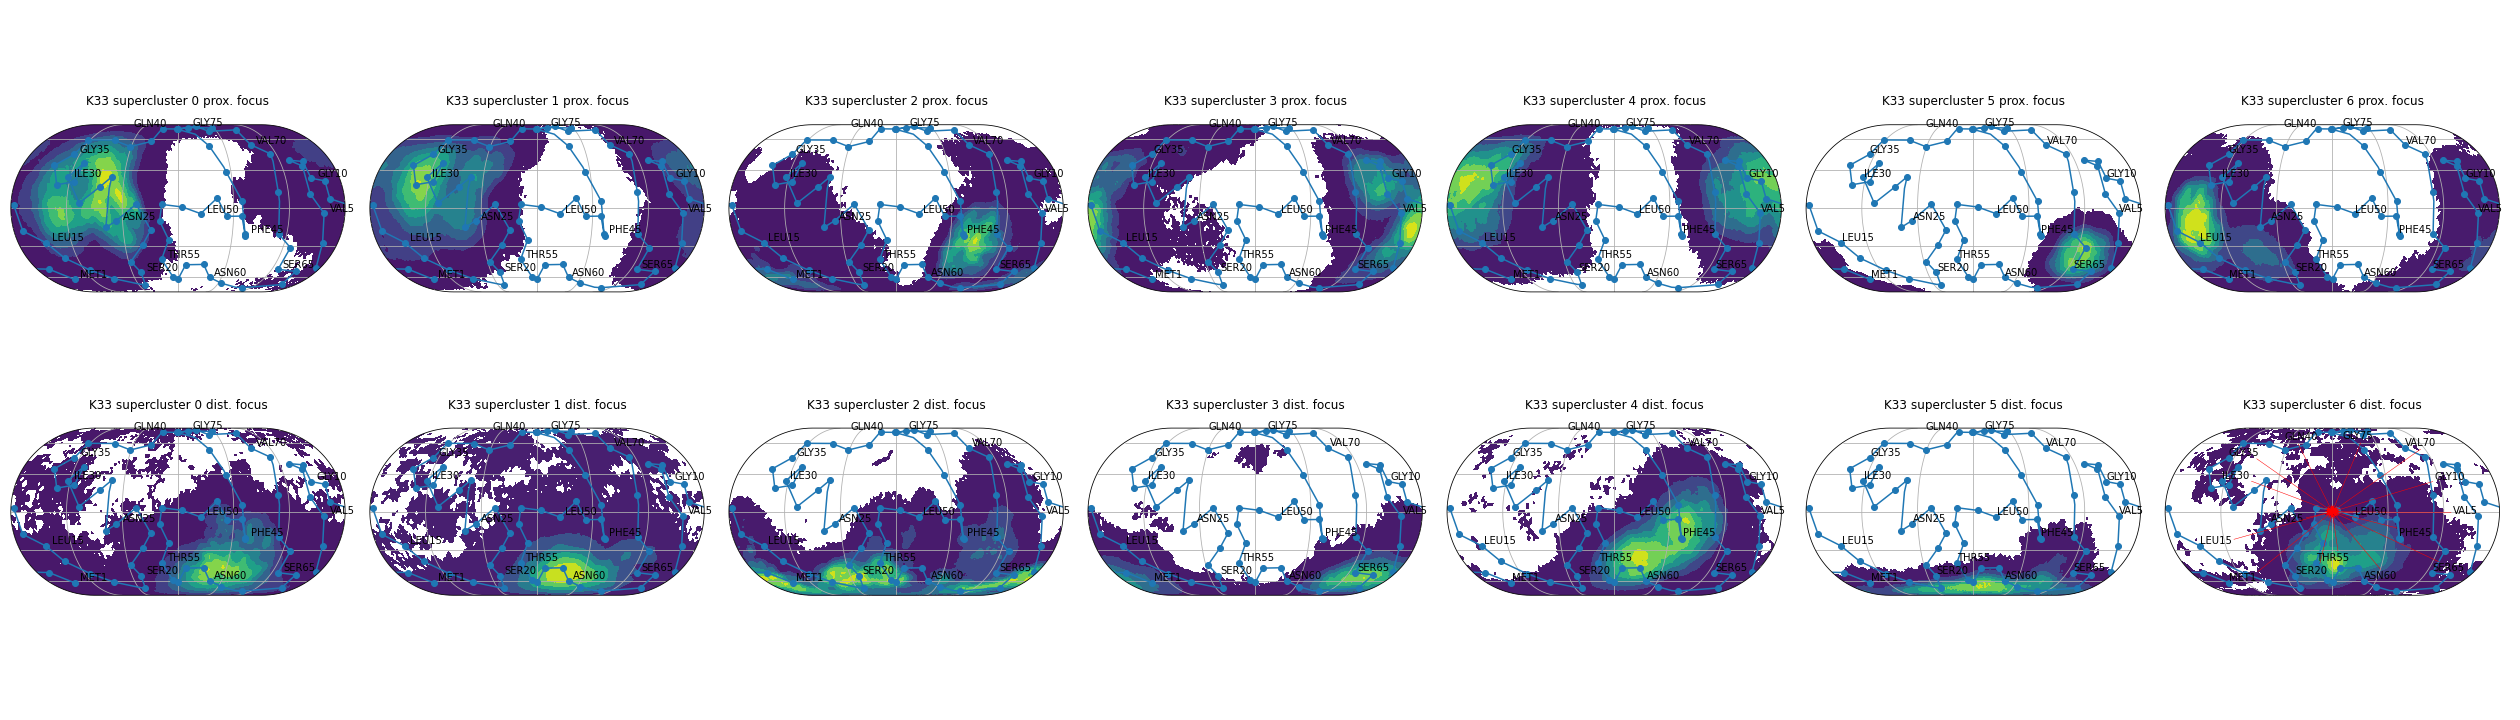

k33 0 [12, 22, 17]
k33 1 [3, 7]
k33 2 [4, 15, 19, 13, 20]
k33 3 [9, 8, 14]
k33 4 [11, 0, 2, 6, 10, 21, 1, 5]
k33 5 [23]
k33 6 [16, 18]


In [101]:
nbins = 200
frames_dict = {}

for ubq_site in UBQ_SITES:
    os.makedirs(f'/home/kevin/projects/living_ppt/sPRE/polar_maps/{ubq_site}', exist_ok=True)
    sub_df = aa_df[aa_df['data', '', 'ubq_site'] == ubq_site]
    traj = md.load_frame(sub_df.iloc[0].name[0], top=sub_df.iloc[0]['data', '', 'top_file'], index=0)
    prox_ind = traj.top.select('resid >= 76')
    CA_prox_ind = traj.top.select('resid >= 76 and name CA')
    dist_ind = traj.top.select('resid < 76')
    fig, axes = plt.subplots(ncols=len(DENDROGRAMS[ubq_site]), nrows=2, figsize=(len(DENDROGRAMS[ubq_site]) * 5, 10), subplot_kw=dict(projection=ccrs.EckertIV()))
    frames_dict[ubq_site] = {}
    for i, (supercluster, clusternums) in enumerate(DENDROGRAMS[ubq_site].items()):
        print(ubq_site, supercluster, clusternums)
        savedir = f'/home/kevin/projects/living_ppt/sPRE/polar_maps/{ubq_site}/files_supercluster_{supercluster}/'
        os.makedirs(savedir, exist_ok=True)
        assert sub_df.shape[0] == polar_coordinates[ubq_site].shape[0] == polar_coordinates_dist_centered[ubq_site].shape[0]
        ind = sub_df['data', '', 'count_id'].isin(clusternums)
        data_prox_centered = polar_coordinates[ubq_site][ind, dist_ind[:, np.newaxis], 4:].reshape((-1, 2))
        data_dist_centered = polar_coordinates_dist_centered[ubq_site][ind, :, :].reshape((-1, 2))
        
        # plotting
        ax1 = axes[0, i]
        ax2 = axes[1, i]
        ax1.set_title(f"{ubq_site.upper()} supercluster {supercluster} prox. focus", y=1.08)
        ax2.set_title(f"{ubq_site.upper()} supercluster {supercluster} dist. focus", y=1.08)
        for ax, data in zip([ax1, ax2], [data_prox_centered, data_dist_centered]):
            ax = add_reference_to_map(ax, use_adjust_text=True)
            x = data[:, 0].flatten()
            y = data[:, 1].flatten()

            H, xedges, yedges = np.histogram2d(x=x, y=y, bins=(nbins, int(nbins / 2)), range=[[-180, 180], [-90, 90]])
            xcenters = np.mean(np.vstack([xedges[0:-1], xedges[1:]]), axis=0)
            ycenters = np.mean(np.vstack([yedges[0:-1], yedges[1:]]), axis=0)
            X, Y = np.meshgrid(xcenters, ycenters)

            lon = np.linspace(-180, 180, nbins)
            lat = np.linspace(-90, 90, int(nbins / 2))
            lon2d, lat2d = np.meshgrid(lon, lat)

            cmap = plt.cm.get_cmap('viridis').copy()
            cmap.set_bad('w', 0.0)
            H = np.ma.masked_where(H < 0.1, H)

            ax.contourf(X, Y, H.T, transform=ccrs.PlateCarree())
            
    frames_dict[ubq_site][supercluster] = []

#     # saving pdbs
#     for (traj_file, frame), row in sub_df[(sub_df[('data', '', 'count_id')].isin(clusternums)) & (sub_df[('data', '', 'rmsd_centroid')] != -1)].iterrows():
#         top_file = row[('data', '', 'top_file')]
#         count_id = row[('data', '', 'count_id')]
#         frame = md.load_frame(traj_file, index=frame, top=top_file)
#         frame = frame.superpose(cryst, 0, atom_indices=CA_prox_ind, ref_atom_indices=CA_ind)
#         fname = savedir + f'centroid_cluster_{count_id}.pdb'
#         frame.save_pdb(fname)
#         frames_dict[ubq_site][supercluster].append(frame)
            
            
    plt.tight_layout()
    fig.savefig(f'/home/kevin/projects/living_ppt/sPRE/polar_maps/{ubq_site}/maps.png', dpi=300)

In [93]:
from scipy.spatial.distance import pdist, squareform

def rmsd_metric(one, two):
    one = one[0]
    two = two[0]
    CA = one.top.select('name CA')
    rmsd = md.rmsd(one, two, frame=0, atom_indices=CA)[0]
    return rmsd

for ubq_site, lower_dict in frames_dict.items():
    for supercluster, frames in lower_dict.items():
        if len(frames) == 1:
            continue
        frames = np.expand_dims(np.array(frames, dtype=object).flatten(), 1)
        
        distances = squareform(pdist(frames, metric=rmsd_metric))
        
        beta = 1
        index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
        print(ubq_site.upper(), supercluster, DENDROGRAMS[ubq_site][supercluster][index])

K6 1 8
K6 2 3
K6 3 1
K29 1 4
K29 2 9
K29 3 11
K29 4 14
K33 0 17
K33 1 3
K33 2 4
K33 3 9
K33 4 6
K33 6 16


# Polar plots for all

In [6]:
polar_coordinates['k6'].shape

(119863, 761, 6)

<IPython.core.display.Javascript object>


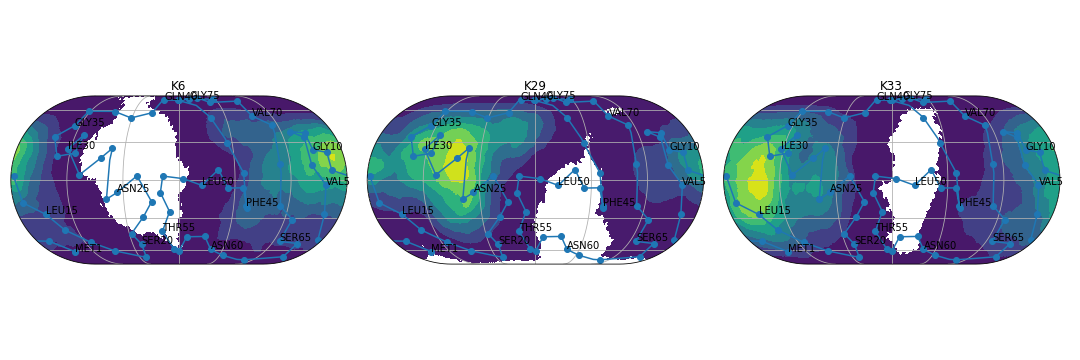

In [14]:
plt.close('all')

nbins = 200

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw=dict(projection=ccrs.EckertIV()))

for ubq_site, ax in zip(UBQ_SITES, axes):
    ax.set_title(ubq_site.upper())
    
    ax = add_reference_to_map(ax)
    
    x = polar_coordinates[ubq_site][..., 4].flatten()
    y = polar_coordinates[ubq_site][..., 5].flatten()
    
    H, xedges, yedges = np.histogram2d(x=x, y=y, bins=(nbins, int(nbins / 2)), range=[[-180, 180], [-90, 90]])
    xcenters = np.mean(np.vstack([xedges[0:-1], xedges[1:]]), axis=0)
    ycenters = np.mean(np.vstack([yedges[0:-1], yedges[1:]]), axis=0)
    X, Y = np.meshgrid(xcenters, ycenters)

    lon = np.linspace(-180, 180, nbins)
    lat = np.linspace(-90, 90, int(nbins / 2))
    lon2d, lat2d = np.meshgrid(lon, lat)

    cmap = plt.cm.get_cmap('viridis').copy()
    cmap.set_bad('w', 0.0)
    H = np.ma.masked_where(H < 0.1, H)

    ax.contourf(X, Y, H.T, transform=ccrs.PlateCarree())
    
plt.tight_layout()
plt.savefig('/home/kevin/projects/living_ppt/sPRE/polar_plots_all.png', dpi=300)
plt.show()

## Isosurface

In [9]:
min_all = np.min(np.vstack([np.min(data[:, :, :3].reshape((-1, 3)), 0) for data in polar_coordinates.values()]), 0)
max_all = np.max(np.vstack([np.max(data[:, :, :3].reshape((-1, 3)), 0) for data in polar_coordinates.values()]), 0)

In [10]:
min_all

array([-5.99861002, -5.74906397, -4.7670846 ])

In [11]:
ranges = [(min_, max_) for min_, max_ in zip(min_all, max_all)]

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


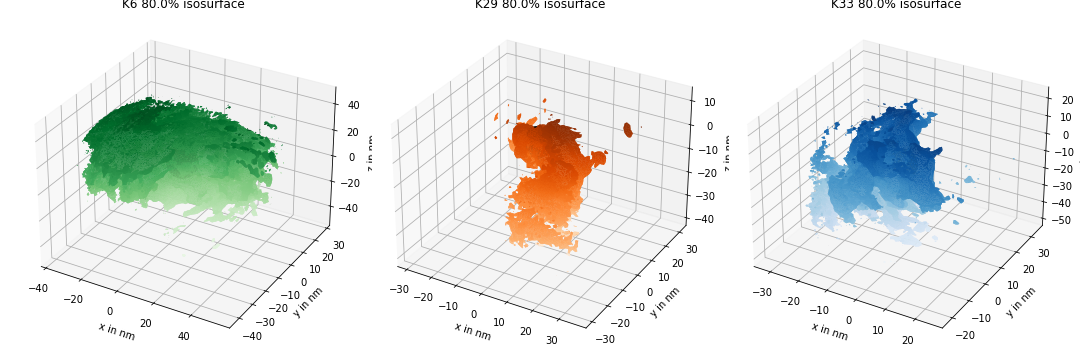

In [13]:
from skimage import measure

plt.close('all')

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': '3d'})

for cmap, ubq_site, ax in zip(['Greens', 'Oranges', 'Blues'], UBQ_SITES, axes):    
    ax.set_xlabel('x in nm')
    ax.set_ylabel('y in nm')
    ax.set_zlabel('z in nm')
    
#     ax.set_xlim([min_all[0], max_all[0]])
#     ax.set_ylim([min_all[1], max_all[1]])
#     ax.set_zlim([min_all[2], max_all[2]])
    
    data = polar_coordinates[ubq_site]
    H, (xedges, yedges, zedges) = np.histogramdd(data[:, :, :3].reshape((-1, 3)), bins=NBINS, range=ranges)
    H = H / H.max()
    mask = H > 0
    
#     xcenters = np.mean(np.vstack([xedges[0:-1], xedges[1:]]), axis=0)
#     ycenters = np.mean(np.vstack([yedges[0:-1], yedges[1:]]), axis=0)
#     zcenters = np.mean(np.vstack([zedges[0:-1], zedges[1:]]), axis=0)
#     X, Y, Z = np.meshgrid(xcenters, ycenters, zcenters)
    
    # do a iso_val cutoff of 0 to capture ALL points in H
    iso_val = 0.0
    verts, faces, _, _ = measure.marching_cubes(H, iso_val)
    
    # get the translation to move cog of verts to cog of H
    x_trans = np.mean(verts[:, 0]) - xedges[int(NBINS/2)]
    y_trans = np.mean(verts[:, 1]) - yedges[int(NBINS/2)]
    z_trans = np.mean(verts[:, 2]) - zedges[int(NBINS/2)]
    
    # redo with a different iso_value
    iso_val = 0.2
    verts, faces, _, _ = measure.marching_cubes(H, iso_val)
    
    ax.set_title(ubq_site.upper() + f' {(1 - iso_val) * 100:.1f}% isosurface')
    
    
    # apply the translations
    verts[:, 0] -= x_trans
    verts[:, 1] -= y_trans
    verts[:, 2] -= z_trans
    
    # plot the isosorf
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1, cmap=cmap)
    
    # add the cog of 1UBQ
    ax.scatter(*np.mean(ref.xyz, 1)[0], s=1000, c='black')
    
plt.tight_layout()
plt.show()

## export to stl

In [ ]:
import numpy as np
from mayavi import mlab

x, y, z = np.ogrid[-10:10:20j, -10:10:20j, -10:10:20j]
s = np.sin(x*y*z)/(x*y*z)

src = mlab.pipeline.scalar_field(s)
mlab.pipeline.iso_surface(src, contours=[s.min()+0.1*s.ptp(), ], opacity=0.3)
mlab.pipeline.iso_surface(src, contours=[s.max()-0.1*s.ptp(), ],)

mlab.show()

# Setdiff with isosurface

In [13]:
histograms = {ubq_site: np.histogramdd(data[:, :, :3].reshape((-1, 3)), bins=NBINS, range=ranges)[0] for ubq_site, data in polar_coordinates.items()}

In [44]:
combined = histograms['k6'] + histograms['k29'] + histograms['k33']
mask = (histograms['k6'] > 0) & (histograms['k29'] > 0) & (histograms['k33'] > 0)

In [46]:
np.unique(np.round(combined, 1))

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.265e+03, 2.302e+03,
       2.363e+03])

In [47]:
np.unique(np.round(combined[combined > 0], 1))

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.265e+03, 2.302e+03,
       2.363e+03])

<IPython.core.display.Javascript object>


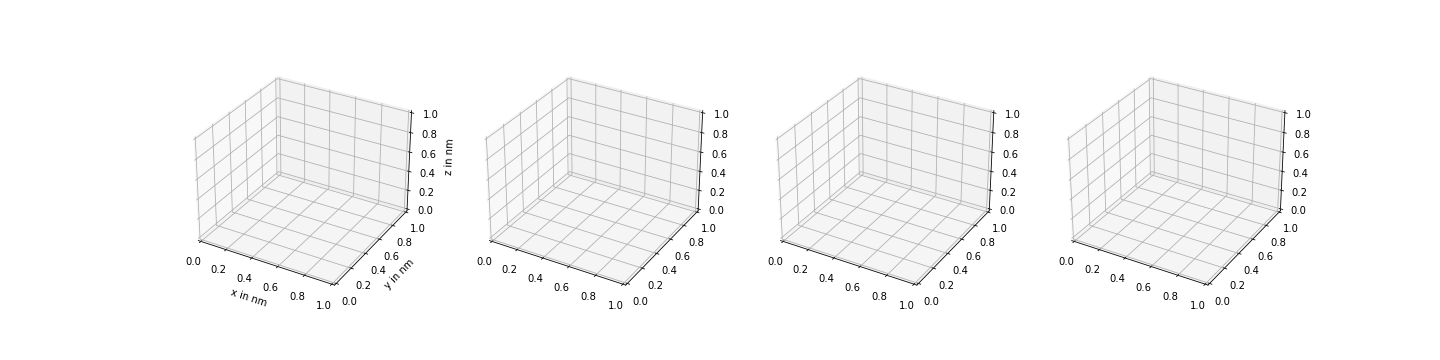

[0.]


Exception: STOP

In [43]:
from skimage import measure

plt.close('all')

fig, axes = plt.subplots(ncols=4, figsize=(20, 5), subplot_kw={'projection': '3d'})

for cmap, ax in zip(['Greys', 'Greens', 'Oranges', 'Blues'], axes):    
    ax.set_xlabel('x in nm')
    ax.set_ylabel('y in nm')
    ax.set_zlabel('z in nm')
    
    if cmap == 'Greys':
        mask = (histograms['k6'] > 0) & (histograms['k29'] > 0) & (histograms['k33'] > 0)
    elif cmap == 'Greens':
        mask = (histograms['k6'] > 0) & (~ (histograms['k29'] > 0)) & (~ (histograms['k33'] > 0))
    elif cmap == 'Oranges':
        mask = (~ (histograms['k6'] > 0)) & (histograms['k29'] > 0) & (~ (histograms['k33'] > 0))
    elif cmap == 'Blues':
        mask = (~ (histograms['k6'] > 0)) & (~ (histograms['k29'] > 0)) & (histograms['k33'] > 0)
    
    H = combined
    
    print(np.unique(np.round(H, 1)))
    raise Exception("STOP")
    
    # do a iso_val cutoff of 0 to capture ALL points in H
    iso_val = 0.0
    try:
        verts, faces, _, _ = measure.marching_cubes(H, iso_val)
    except RuntimeError:
        print(cmap)
        raise
    
    # get the translation to move cog of verts to cog of H
    x_trans = np.mean(verts[:, 0]) - xedges[int(NBINS/2)]
    y_trans = np.mean(verts[:, 1]) - yedges[int(NBINS/2)]
    z_trans = np.mean(verts[:, 2]) - zedges[int(NBINS/2)]
    
    # redo with a different iso_value
    iso_val = 0.0
    verts, faces, _, _ = measure.marching_cubes(H, iso_val)
    
    ax.set_title(ubq_site.upper() + f' {(1 - iso_val) * 100:.1f}% isosurface')
    
    
    # apply the translations
    verts[:, 0] -= x_trans
    verts[:, 1] -= y_trans
    verts[:, 2] -= z_trans
    
    # plot the isosorf
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1, cmap=cmap)
    
    # add the cog of 1UBQ
    ax.scatter(*np.mean(ref.xyz, 1)[0], s=1000, c='black')
    
plt.tight_layout()
plt.show()

# Check the polar plotting internals

In [7]:
from sklearn.datasets import make_blobs
from xplor.functions.analysis import appendLonLatTraj
%matplotlib notebook

<IPython.core.display.Javascript object>


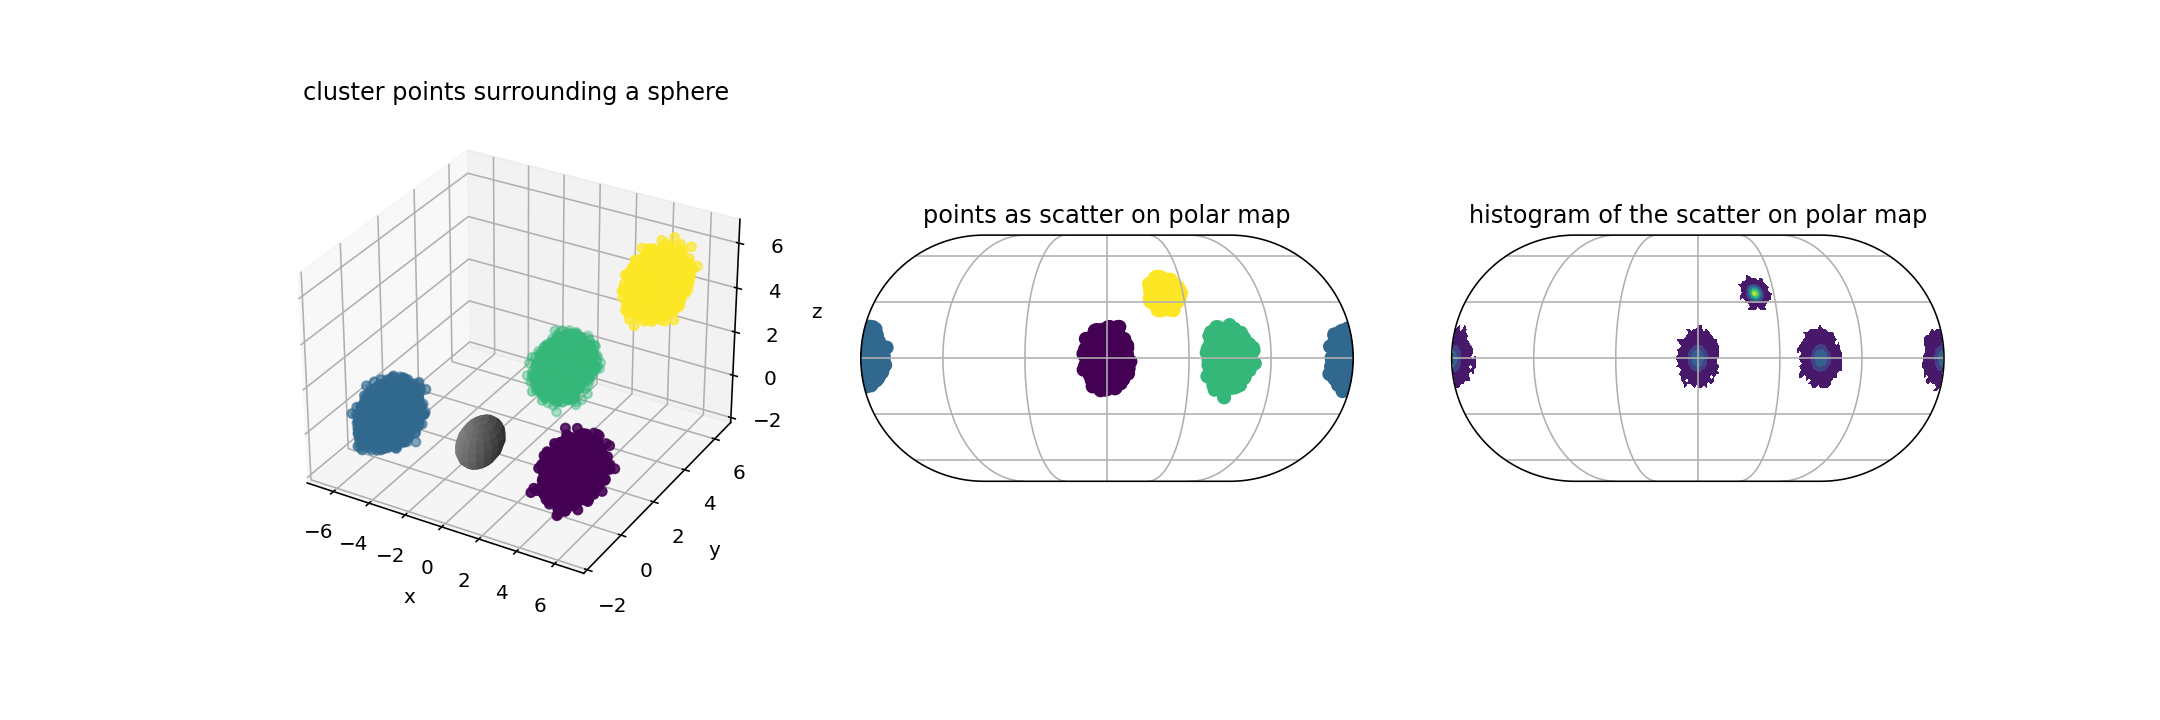

In [43]:
plt.close('all')

nbins = 200

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection=ccrs.EckertIV())
ax3 = fig.add_subplot(133, projection=ccrs.EckertIV())

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="b")
ax1.plot_surface(x, y, z, color='grey')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

blobs, labels = make_blobs(50000, 3, centers=[[5, 0, 0], [-5, 0, 0], [0, 5, 0], [5, 5, 5]], cluster_std=0.4)
ax1.scatter(*blobs.T, c=labels)

ax2.gridlines()
ax2.set_global()
ax3.gridlines()
ax3.set_global()

lons_lats = appendLonLatTraj(np.expand_dims(blobs,0))
x = lons_lats[:, :, 4].flatten()
y = lons_lats[:, :, 5].flatten()

H, xedges, yedges = np.histogram2d(x=x, y=y, bins=(nbins, int(nbins / 2)), range=[[-180, 180], [-90, 90]])
xcenters = np.mean(np.vstack([xedges[0:-1], xedges[1:]]), axis=0)
ycenters = np.mean(np.vstack([yedges[0:-1], yedges[1:]]), axis=0)
X, Y = np.meshgrid(xcenters, ycenters)

lon = np.linspace(-180, 180, nbins)
lat = np.linspace(-90, 90, int(nbins / 2))
lon2d, lat2d = np.meshgrid(lon, lat)

cmap = plt.cm.get_cmap('viridis').copy()
cmap.set_bad('w', 0.0)
H = np.ma.masked_where(H == 0, H)

ax2.scatter(x, y, c=labels, transform=ccrs.PlateCarree())

ax3.contourf(X, Y, H.T, transform=ccrs.PlateCarree())

ax1.set_title('cluster points surrounding a sphere')
ax2.set_title('points as scatter on polar map')
ax3.set_title('histogram of the scatter on polar map')

plt.show()

## Render a cluster with all structures as wires to see its true expanse

In [4]:
aa_df = pd.read_hdf('/home/kevin/git/xplor_functions/xplor/data/all_frames_sPRE_sim.h5')

### proximal

Focus on K29 supercluster with 3, 7, 9, 10 and 16 with special rgards to residue LYS29 

In [5]:
cryst, cryst_CA, _ = center_ref_and_load()

### Aligned on prox

In [96]:
clusters = [3, 7, 9, 10, 16]
clusters = list(map(lambda x: x - 1, clusters))

sub_df = aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29') & ((aa_df[('data', '', 'count_id')] + 1).isin(clusters))]
sub_df = sub_df.reset_index()

print(sub_df.shape)

# for i, (traj_file, rows) in sub_df.groupby()
for i, (traj_file, rows) in enumerate(sub_df.groupby('traj_file')):
    frames = rows['frame'].values
    top_file = rows[('data', '', 'top_file')].unique()
    assert len(top_file) == 1
    top_file = top_file[0]
    
    traj = md.load(traj_file, top=top_file)[frames]
    assert len(frames) == traj.n_frames
    
    if i == 0:
        traj_out = copy.deepcopy(traj)
    else:
        traj_out = traj_out.join(traj)
        
    print(i, traj_out.n_frames)
        
    # if i == 5:
    #     break
        
prox_CA = traj_out.top.select('resid >= 76 and name CA')
print(prox_CA.shape, cryst_CA.shape)
traj_out = traj_out.superpose(cryst, atom_indices=prox_CA, ref_atom_indices=cryst_CA)
    
traj_out[0].save_pdb('/mnt/data/kevin/xplor_analysis_files/supercluster_k29_3_7_9_10_16_to_plot_all.pdb')
traj_out.save_xtc('/mnt/data/kevin/xplor_analysis_files/supercluster_k29_3_7_9_10_16_to_plot_all.xtc')

(4551, 782)
0 1270
1 1291
2 1330
3 1444
4 1446
5 1559
6 1600
7 1735
8 1759
9 1762
10 1861
11 1907
12 1975
13 1981
14 1986
15 2042
16 2060
17 2101
18 2285
19 2334
20 2511
21 2514
22 2730
23 2838
24 2843
25 2858
26 2876
27 2877
28 2903
29 2912
30 2962
31 3089
32 3115
33 3320
34 3402


/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (GLN, MET)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (ILE, GLN)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (PHE, ILE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/home/kevin/.conda/envs/py39_tf2/lib/python3.9/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (VAL, PHE)
  warnings.warn("WARN

35 3491
36 3505
37 3598
38 4550
39 4551
(76,) (76,)


In [ ]:
from encodermap.plot.plotting import render_vmd

additional_lines = ['mol load pdb /mnt/data/kevin/xplor_analysis_files/supercluster_k29_3_7_9_10_16_to_plot_all.pdb xtc /mnt/data/kevin/xplor_analysis_files/supercluster_k29_3_7_9_10_16_to_plot_all.xtc',
                    'mol off 0',
                    'mol addrep 1',
                    'mol addrep 1',
                    # select rep mol
                    'mol modselect 0 1 residue 76 to 152',
                   f'mol modselect 1 1 residue {75 + 29} and resname LYQ and not name C and not name O and not name N and not name H',
                    'mol modselect 2 1 residue 0 to 75',
                    # style rep mol
                    'mol modstyle 0 1 newcartoon',
                    'mol modstyle 1 1 licorice',
                    # material rep mol
                    'mol modmaterial 0 1 AOChalky',
                    'mol modmaterial 1 1 AOChalky',
                    # color rep mol
                    'mol modcolor 0 1 structure',
                    'mol modcolor 1 1 colorid 3',
                    # drawframes mol rep
                    'mol drawframes 1 1 0:100:99999',
                    'mol drawframes 1 2 0:1:99999',
                    # scale and other stuff
                    'scale by 2'
                   ]

image = render_vmd(None, additional_lines=additional_lines, scale=5.0)
plt.close('all')
plt.imshow(image)

For the ssupdate function to work encodermap/vmd/sscache.tcl will be sourced within vmd. If no Error is thrown the file is present.


### Aligned with everything

In [8]:
clusters = [3, 7, 9, 10, 16]
clusters = list(map(lambda x: x - 1, clusters))

sub_df = aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29') & ((aa_df[('data', '', 'count_id')] + 1).isin(clusters))]
sub_df = sub_df.reset_index()

print(sub_df.shape)

# for i, (traj_file, rows) in sub_df.groupby()
for i, (traj_file, rows) in enumerate(sub_df.groupby('traj_file')):
    frames = rows['frame'].values
    top_file = rows[('data', '', 'top_file')].unique()
    assert len(top_file) == 1
    top_file = top_file[0]
    
    traj = md.load(traj_file, top=top_file)[frames]
    assert len(frames) == traj.n_frames
    
    if i == 0:
        traj_out = copy.deepcopy(traj)
    else:
        traj_out = traj_out.join(traj)
        
    print(i, traj_out.n_frames)
        
    # if i == 5:
    #     break
        
CA = traj_out.top.select('name CA')
traj_out = traj_out.superpose(traj_out, atom_indices=CA)
    
traj_out[0].save_pdb('/mnt/data/kevin/xplor_analysis_files/supercluster_k29_3_7_9_10_16_to_plot_all_aligned_to_all.pdb')
traj_out.save_xtc('/mnt/data/kevin/xplor_analysis_files/supercluster_k29_3_7_9_10_16_to_plot_all_aligned_to_all.xtc')

(4551, 782)
0 1270
1 1291
2 1330
3 1444
4 1446
5 1559
6 1600
7 1735
8 1759
9 1762
10 1861
11 1907
12 1975
13 1981
14 1986
15 2042
16 2060
17 2101
18 2285
19 2334
20 2511
21 2514
22 2730
23 2838
24 2843
25 2858
26 2876
27 2877
28 2903
29 2912
30 2962
31 3089
32 3115
33 3320
34 3402
35 3491
36 3505
37 3598
38 4550
39 4551


In [9]:
clusters = [4, 11, 15, 17]
clusters = list(map(lambda x: x - 1, clusters))

sub_df = aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29') & ((aa_df[('data', '', 'count_id')] + 1).isin(clusters))]
sub_df = sub_df.reset_index()

print(sub_df.shape)

# for i, (traj_file, rows) in sub_df.groupby()
for i, (traj_file, rows) in enumerate(sub_df.groupby('traj_file')):
    frames = rows['frame'].values
    top_file = rows[('data', '', 'top_file')].unique()
    assert len(top_file) == 1
    top_file = top_file[0]
    
    traj = md.load(traj_file, top=top_file)[frames]
    assert len(frames) == traj.n_frames
    
    if i == 0:
        traj_out = copy.deepcopy(traj)
    else:
        traj_out = traj_out.join(traj)
        
    print(i, traj_out.n_frames)
        
    # if i == 5:
    #     break
        
CA = traj_out.top.select('name CA')
traj_out = traj_out.superpose(traj_out, atom_indices=CA)
    
traj_out[0].save_pdb('/mnt/data/kevin/xplor_analysis_files/supercluster_k29_4_11_15_17_to_plot_all_aligned_to_all.pdb')
traj_out.save_xtc('/mnt/data/kevin/xplor_analysis_files/supercluster_k29_4_11_15_17_to_plot_all_aligned_to_all.xtc')

(11525, 782)
0 70
1 131
2 1714
3 2016
4 2081
5 2297
6 3118
7 4560
8 5618
9 5650
10 5654
11 6252
12 6275
13 6283
14 6284
15 6333
16 6360
17 6680
18 6946
19 7301
20 8547
21 8570
22 8685
23 9303
24 11525


### distal

Focus on K29 cluster 6, 7 and k33 15. They are very dissimilar.

### All frames

In [10]:
sub_df = aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29')].sample(5000)
sub_df = sub_df.reset_index()

print(sub_df.shape)

# for i, (traj_file, rows) in sub_df.groupby()
for i, (traj_file, rows) in enumerate(sub_df.groupby('traj_file')):
    frames = rows['frame'].values
    top_file = rows[('data', '', 'top_file')].unique()
    assert len(top_file) == 1
    top_file = top_file[0]
    
    traj = md.load(traj_file, top=top_file)[frames]
    assert len(frames) == traj.n_frames
    
    if i == 0:
        traj_out = copy.deepcopy(traj)
    else:
        traj_out = traj_out.join(traj)
        
    print(i, traj_out.n_frames)
        
    # if i == 5:
    #     break
        
prox_CA = traj_out.top.select('resid >= 76 and name CA')
dist_CA = traj_out.top.select('resid < 76 and name CA')
print(prox_CA.shape, cryst_CA.shape)
traj_out = traj_out.superpose(cryst, atom_indices=dist_CA, ref_atom_indices=cryst_CA)
    
traj_out[0].save_pdb('/mnt/data/kevin/xplor_analysis_files/k29_all_structures_dist_centered.pdb')
traj_out.save_xtc('/mnt/data/kevin/xplor_analysis_files/k29_all_structures_dist_centered.xtc')

(5000, 782)
0 251
1 475
2 705
3 933
4 1176
5 1404
6 1615
7 1845
8 2057
9 2272
10 2499
11 2718
12 2738
13 2789
14 2841
15 2883
16 2903
17 2914
18 2927
19 2940
20 2955
21 2971
22 2991
23 3004
24 3017
25 3030
26 3039
27 3051
28 3075
29 3085
30 3101
31 3110
32 3126
33 3141
34 3152
35 3166
36 3178
37 3190
38 3199
39 3214
40 3230
41 3243
42 3256
43 3267
44 3280
45 3294
46 3338
47 3349
48 3362
49 3375
50 3390
51 3412
52 3432
53 3445
54 3459
55 3474
56 3484
57 3636
58 3834
59 3990
60 4147
61 4321
62 4506
63 4674
64 4852
65 5000
(76,) (76,)


### The two clusters

In [12]:
count_id = 7

sub_df = aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29') & ((aa_df[('data', '', 'count_id')] + 1) == count_id)]
sub_df = sub_df.reset_index()

print(sub_df.shape)

# for i, (traj_file, rows) in sub_df.groupby()
for i, (traj_file, rows) in enumerate(sub_df.groupby('traj_file')):
    frames = rows['frame'].values
    top_file = rows[('data', '', 'top_file')].unique()
    assert len(top_file) == 1
    top_file = top_file[0]
    
    traj = md.load(traj_file, top=top_file)[frames]
    assert len(frames) == traj.n_frames
    
    if i == 0:
        traj_out = copy.deepcopy(traj)
    else:
        traj_out = traj_out.join(traj)
        
    print(i, traj_out.n_frames)
        
    # if i == 5:
    #     break
        
prox_CA = traj_out.top.select('resid >= 76 and name CA')
dist_CA = traj_out.top.select('resid < 76 and name CA')
print(prox_CA.shape, cryst_CA.shape)
traj_out = traj_out.superpose(cryst, atom_indices=dist_CA, ref_atom_indices=cryst_CA)
    
traj_out[0].save_pdb(f'/mnt/data/kevin/xplor_analysis_files/k29_cluster_{count_id}_dist_centered.pdb')
traj_out.save_xtc(f'/mnt/data/kevin/xplor_analysis_files/k29_cluster_{count_id}_dist_centered.xtc')

(1051, 782)
0 10
1 19
2 22
3 166
4 188
5 998
6 1029
7 1049
8 1051
(76,) (76,)


## Check the distal structures

### Make a blob at the position of residue GLQ76

In [14]:
for (ubq_site, count_id), rows in aa_df.groupby([('data', '', 'ubq_site'), ('data', '', 'count_id')]):
    if count_id == -1:
        continue
        
    rows = rows.reset_index()
    
    break

In [21]:
aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29') & (aa_df[('data', '', 'count_id')] == 14)]

data  \
                                                                                                              
                                                                                                   top_file   
traj_file                                          frame                                                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k2... 3452   /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   3488   /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   3489   /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   3495   /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
                                                   3547   /home/andrejb/Research/SIMS/2017_04_27_G_2ub_k...   
...                                                                                                     ...   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 283    /home/andrejb/Research/SIMS/2017_06_28_GfM_SMm...   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 151    /home/andrejb/Research/SIMS/2017_06_28_GfM_SMm...   
                                                   153    /home/andrejb/Research/SIMS/2017_06_28_GfM_SMm...   
                                                   155    /home/andrejb/Research/SIMS/2017_06_28_GfM_SMm...   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 34     /home/andrejb/Research/SIMS/2017_06_28_GfM_SMm...   

                                                                   \
                                                                    
                                                             time   
traj_file                                          frame            
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k2... 3452   34520.0   
                                                   3488   34880.0   
                                                   3489   34890.0   
                                                   3495   34950.0   
                                                   3547   35470.0   
...                                                           ...   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 283     2830.0   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 151     1510.0   
                                                   153     1530.0   
                                                   155     1550.0   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 34       340.0   

                                                                       sPRE  \
                                                                   proximal   
                                                         proximal MET1 sPRE   
traj_file                                          frame                      
/home/andrejb/Research/SIMS/2017_04_27_G_2ub_k2... 3452            0.490216   
                                                   3488            0.434623   
                                                   3489            0.603045   
                                                   3495            0.418513   
                                                   3547            0.790600   
...                                                                     ...   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 283             0.546287   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 151             0.487654   
                                                   153             0.339017   
                                                   155             0.506116   
/home/andrejb/Research/SIMS/2017_06_28_GfM_SMmi... 34              1.411627   

                                                                             \
                                                                              
                                                         

In [44]:
ref, idx, labels = center_ref_and_load()

rows = aa_df[(aa_df[('data', '', 'ubq_site')] == 'k29') & (aa_df[('data', '', 'count_id')] == 14)]
rows = rows.reset_index()
print(len(rows))

for i, (traj_file, other_rows) in enumerate(rows.groupby('traj_file')):
    frames = other_rows['frame']
    top_file = other_rows[('data', '', 'top_file')].unique()
    assert len(top_file) == 1
    top_file = top_file[0]
    
    traj = md.load(traj_file, top=top_file)[frames]
    
    if i == 0:
        traj_out = copy.deepcopy(traj)
    else:
        traj_out = traj_out.join(traj)
else:
    dist_CA = traj_out.top.select('resid < 76 and name CA')
    traj_out = traj_out.superpose(ref, atom_indices=dist_CA, ref_atom_indices=idx)
    
assert len(rows) == traj_out.n_frames

92


In [48]:
traj_coords[0, dist_CA, 4]

array([-1.59150361e+02, -1.72970005e+02,  1.72878180e+02,  1.59864170e+02,
        1.58309114e+02,  1.37834215e+02,  1.52131822e+02,  1.32217299e+02,
        1.57973437e+02,  1.59639156e+02,  1.64260667e+02,  1.60498913e+02,
       -1.79154551e+02, -1.70021099e+02, -1.52003538e+02, -1.40400494e+02,
       -1.17032464e+02, -1.02884205e+02, -5.83504768e+01, -5.51053208e+01,
       -6.25801808e+01, -4.43090627e+01, -3.33499457e+01, -4.77951503e+01,
       -7.03028503e+01, -7.82238958e+01, -6.90664836e+01, -8.32461817e+01,
       -1.06829083e+02, -1.17565724e+02, -1.00438178e+02, -1.09379886e+02,
       -1.29043351e+02, -1.32217846e+02, -1.19558008e+02, -1.10519708e+02,
       -7.35492050e+01, -4.60509932e+01, -2.45893128e+01, -2.07199508e-02,
       -1.81220799e+01,  1.32407665e+01,  2.93507948e+01,  5.34371905e+01,
        6.30854577e+01,  6.49381123e+01,  5.99856651e+01,  4.36016327e+01,
        3.16142102e+01,  1.74717315e+01, -1.14491878e+00, -2.16671086e+01,
       -2.49965970e+01, -

<IPython.core.display.Javascript object>


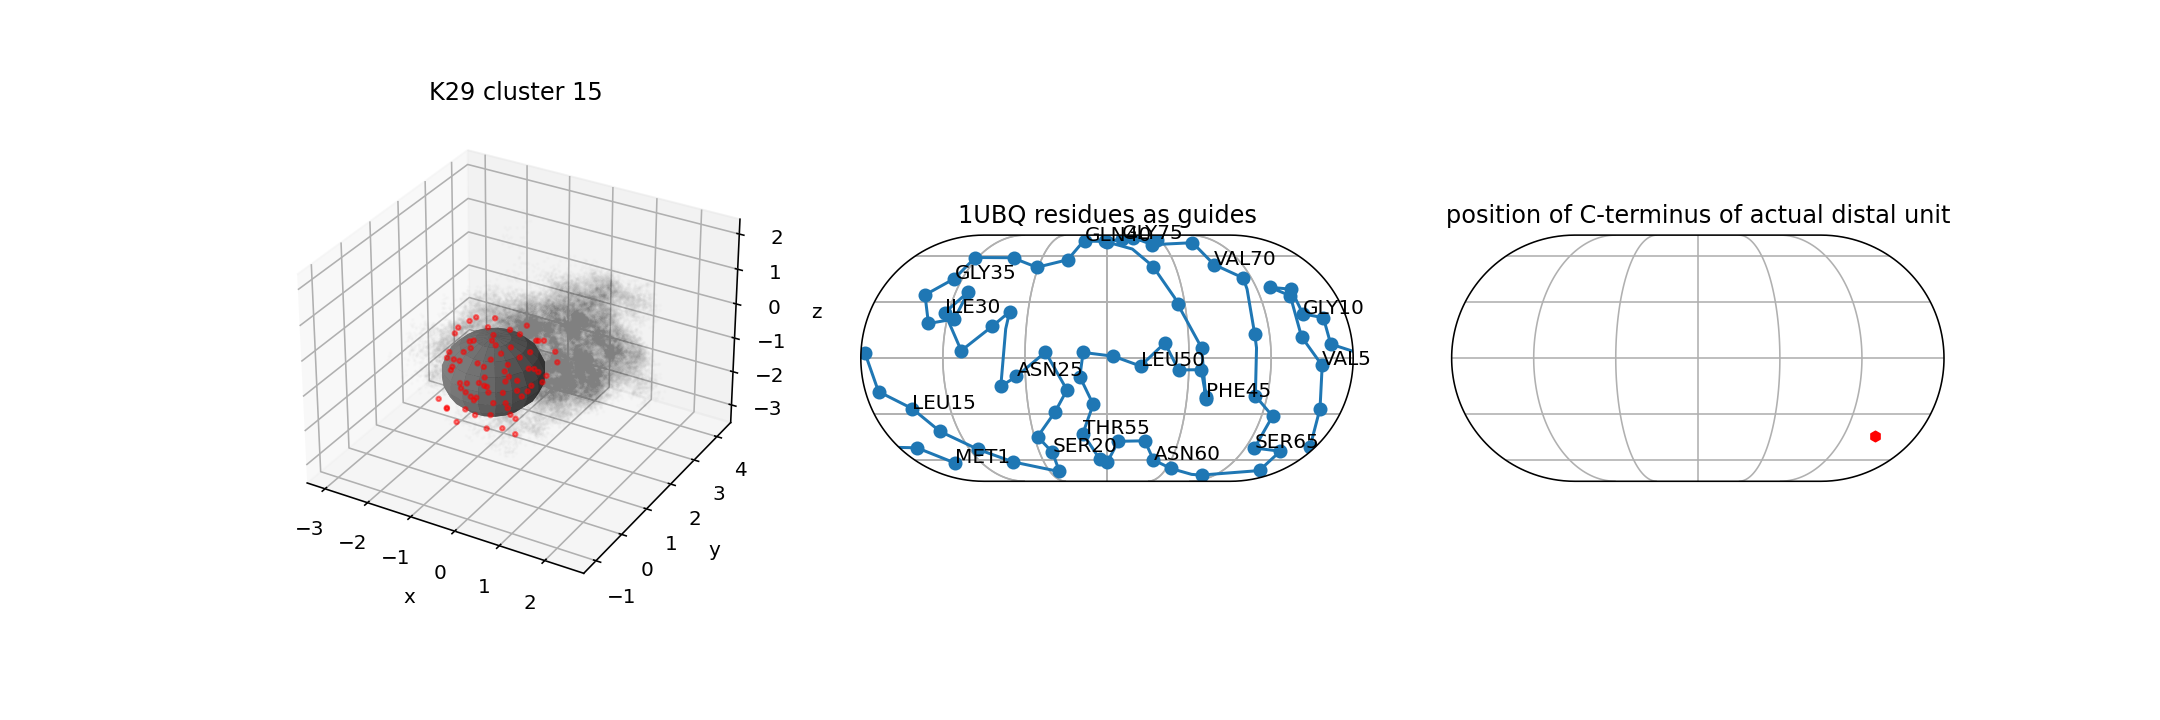

In [52]:
from sklearn.datasets import make_blobs
from xplor.functions.analysis import appendLonLatTraj
%matplotlib notebook

plt.close('all')

nbins = 200

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection=ccrs.EckertIV())
ax3 = fig.add_subplot(133, projection=ccrs.EckertIV())

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="b")
ax1.plot_surface(x, y, z, color='grey')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

dist_CA = traj_out.top.select('resid < 76 and name CA')
glq_CA = traj_out.top.select('resname GLQ and name CA')
prox_ind = traj_out.top.select('resid >= 76')

ax1.scatter(*traj_coords[:, prox_ind[:, np.newaxis], :3].reshape(-1, 3).T, s=1, c='grey', alpha=0.01)
ax1.scatter(*traj_coords[0, dist_CA[:, np.newaxis], :3].reshape(-1, 3).T, s=5, c='red', alpha=0.5)

ax2.gridlines()
ax2.set_global()
ax3.gridlines()
ax3.set_global()

add_reference_to_map(ax2)

x = traj_coords[0, glq_CA[:, np.newaxis], 4].flatten()
y = traj_coords[0, glq_CA[:, np.newaxis], 5].flatten()
ax3.scatter(x, y, c='red', s=25, marker='h',  transform=ccrs.PlateCarree())

H, xedges, yedges = np.histogram2d(x=x, y=y, bins=(nbins, int(nbins / 2)), range=[[-180, 180], [-90, 90]])
xcenters = np.mean(np.vstack([xedges[0:-1], xedges[1:]]), axis=0)
ycenters = np.mean(np.vstack([yedges[0:-1], yedges[1:]]), axis=0)
X, Y = np.meshgrid(xcenters, ycenters)

lon = np.linspace(-180, 180, nbins)
lat = np.linspace(-90, 90, int(nbins / 2))
lon2d, lat2d = np.meshgrid(lon, lat)

cmap = plt.cm.get_cmap('viridis').copy()
cmap.set_bad('w', 0.0)
H = np.ma.masked_where(H == 0, H)

# ax2.scatter(x, y, c=labels, transform=ccrs.PlateCarree())

# ax3.contourf(X, Y, H.T, transform=ccrs.PlateCarree())

ax1.set_title('K29 cluster 15')
ax2.set_title('1UBQ residues as guides')
ax3.set_title('position of C-terminus of actual distal unit')

plt.show()

### Plot the scatter of the distal unit's residues after being aligned